In [1]:
#Imports
import pandas as pd
import os
import tensorflow as tf

from scipy.stats import ks_2samp
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

import sys  
sys.path.append("../../")  
from utils.models import *
from utils.datahandling import *
from utils.modelrunner import *

import wandb
import logging
logging.getLogger("wandb").setLevel(logging.ERROR)
logging.getLogger('tensorflow').setLevel(logging.ERROR)

os.environ['WANDB_SILENT'] = 'true'
os.environ['WANDB_CONSOLE'] = 'off'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
# Define constants and configurations
num_users = 1
num_features = 7  # Number of features
sequence_length = 25
evaluation_interval = 168
mae_threshold = 0.1
ks_threshold = 0.05

In [4]:
# Load data
cwd = os.path.normpath(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
df = pd.read_csv(cwd+'/data/3final_data/Final_Grossload_dataset.csv', index_col='Date')
df.index = pd.to_datetime(df.index)
df.fillna(0, inplace=True)

# Filter data for a specific period
start_date = df.index.min() + pd.DateOffset(years=1)
end_date = start_date + pd.DateOffset(months=4)
#end_date = df.index.max()
df = df[(df.index >= start_date) & (df.index < end_date)]

df = min_max_scaling(df)

# Prepare data arrays for each user
df_array = [df[[f'User{idx+1}', 'temp', 'rhum', 'wspd', 'PC1', 'hour sin', 'hour cos', f'User{idx+1}_lag_24hrs']] for idx in range(num_users)]


# Example for user 1
df_user1_dynamic = df_array[0].copy()
df_user1_dynamic.reset_index(inplace=True, drop=True)
df_user1_dynamic.head(2)

,User1,temp,rhum,wspd,PC1,hour sin,hour cos,User1_lag_24hrs
0,0.044257,0.386364,0.818182,0.0,0.157571,0.50000,1.000000,0.085353
1,0.068493,0.386364,0.818182,0.0,0.157571,0.62941,0.982963,0.352476


In [5]:
loss = tf.keras.losses.MeanSquaredError()
metrics=[
    tf.keras.metrics.RootMeanSquaredError(), 
    tf.keras.metrics.MeanAbsolutePercentageError(),
    tf.keras.metrics.MeanAbsoluteError(),
]

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,mode='min')
timing_callback = TimingCallback()
custom_callback = CustomCallback()

callbacks=[early_stopping, timing_callback, custom_callback]

# Model related configurations
model = tf.keras.models.load_model(cwd+r'\src\time_series\Locallearning\TS_LL_Grossload_Forecasting_Benchmark\wandb\TS_LL_Grossload_bilstm_u1_rd5.keras', compile=False)

model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=metrics)

In [6]:
# Stream data simulation
stream_data = df_user1_dynamic.values  # Assuming df_user1_dynamic has 7 features as columns
stream_buffer = []
stream_predictions = []
cd_mae_counter = 0
cd_ks_counter = 0
previous_mae = np.NaN
previous_rmse = np.NaN
total_mae = 0
total_rmse = 0

# Enumerate through the data stream
for idx, data in enumerate(stream_data):
    
    # Buffer:  Append data to the buffer and pop oldest if sequence_length is surpassed.
    stream_buffer.append(data)
    if len(stream_buffer) > sequence_length:
        # Remove the oldest data point to maintain the buffer size
        stream_buffer.pop(0)

    # Ensure buffer size is exactly 24 for prediction
    if len(stream_buffer) == sequence_length:  # sequence_length is 25
        # Prepare data for prediction (last 24 entries)
        x_pred = np.array([stream_buffer[:-1]])  # Exclude the last entry for prediction

        # Make a prediction
        prediction = model.predict(x_pred, callbacks=callbacks)
        stream_predictions.append(prediction[0, 0])
        
        # Calculate MAE for the prediction using the 25th value
        actual = stream_buffer[-1][0]  # The 25th value, assuming the first column is User1 data
        rmse = np.sqrt(np.mean((actual -  prediction[0, 0]) ** 2))
        mae = np.abs(actual - prediction[0, 0])
        total_mae += mae
        total_rmse += rmse

        # Remove the oldest data point to maintain the buffer size for next iteration
        stream_buffer.pop(0)

    # Check and evaluate at every evaluation_interval
    if (idx + 1) % evaluation_interval == 0:
        # Ensure we have enough predictions to compare
        if len(stream_predictions) >= evaluation_interval:
            # Calculate RMSE for the evaluation window
            actual_values = stream_data[idx-evaluation_interval+1:idx+1, 0]
            predicted_values = stream_predictions[-evaluation_interval:]
            rmse = np.sqrt(np.mean((actual_values - predicted_values) ** 2))

            # Check for concept drift using MAE
            if not np.isnan(previous_mae) and mae > previous_mae * (1 + mae_threshold):
                cd_mae_counter += 1

            # Check for concept drift using KS test
            if ks_2samp(actual_values, predicted_values).statistic > ks_threshold:
                cd_ks_counter += 1

            # Update previous MAE
            previous_mae = total_mae / evaluation_interval
            previous_rmse = total_rmse / evaluation_interval
            total_mae = 0
            total_rmse = 0

            print(f"RMSE for the current evaluation window: {rmse}")

print(f"MAE for the current evaluation window: {previous_mae}")
print(f"RMSE for the current evaluation window: {previous_rmse}")
print("Concept drift MAE: ", cd_mae_counter)
print("Concept drift Kolmogorov-Smirnov test: ", cd_ks_counter)

1/1 [==============================] - 0s 15ms/step
RMSE for the current evaluation window: 0.17342003186294494
1/1 [==============================] - 0s 14ms/step
RMSE for the current evaluation window: 0.17617305151214016
1/1 [==============================] - 0s 14ms/step
RMSE for the current evaluation window: 0.16246945639014168
1/1 [==============================] - 0s 14ms/step
RMSE for the current evaluation window: 0.1174885924704144
1/1 [==============================] - 0s 16ms/step
RMSE for the current evaluation window: 0.15906739989183685
1/1 [==============================] - 0s 14ms/step
RMSE for the current evaluation window: 0.15196530914331727
1/1 [==============================] - 0s 14ms/step
RMSE for the current evaluation window: 0.10601183718629577
1/1 [==============================] - 0s 15ms/step
RMSE for the current evaluation window: 0.11727178387099452
1/1 [==============================] - 0s 15ms/step
RMSE for the current evaluation window: 0.14344450616

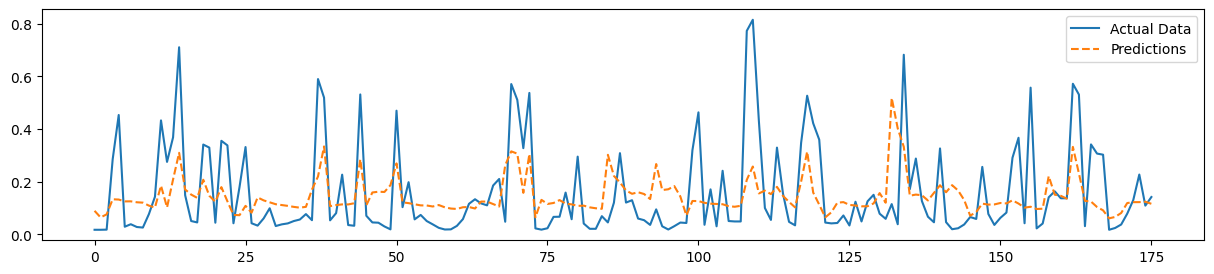

In [7]:
# Plotting to visualize the results
plt.figure(figsize=(15, 3))
plt.plot(df_user1_dynamic['User1'][124:300].values, label='Actual Data')
plt.plot(stream_predictions[124:300], label='Predictions', linestyle='dashed')
plt.legend()
plt.show()